In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import colorbar
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os,glob,pickle,re,sys,json
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
from nilearn import datasets, input_data
import pingouin as pg
import nibabel as nib

import enigmatoolbox
from enigmatoolbox.utils.parcellation import surface_to_parcel,parcel_to_surface
from enigmatoolbox.datasets import fetch_ahba

#BrainSmash
from brainsmash.mapgen.base import Base 
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp

from ptitprince import half_violinplot

sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid")

#!{sys.prefix}/bin/pip install -e ../
import src.functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Variables declaration and filepaths

In [2]:
os.environ["PATH"]+=':/home/tumnic/gcastrillon/workbench_v1.4.2/bin_linux64'
os.environ["QT_QPA_PLATFORM"]='offscreen'

os.environ["OUTDATED_IGNORE"]='1'
#os.environ["TEMP"]=os.path.join(os.environ["HOME"],'tmp')
os.environ["TMP"]=os.path.join(os.environ["HOME"],'tmp')
import tempfile
tempfile.tempdir=os.environ["TMP"]
#tempfile.gettempdir()

root_dir = '../data'
results_dir = '../results'
img_dir = os.path.join(root_dir,'img_files')

thr=0.25
thr_i = "%i" % (thr*100)

fc_res_label = 'cpac_v1.4.0'
dti_res_label = 'mrtrix3_v0.4.2'
pipeline='_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1' if fc_res_label=='cpac_v1.6.1' else '_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1'
ref_img = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz'
#!lh_dist_full = np.loadtxt('ext_data/brainsmash/example_data/LeftParcelGeodesicDistmat.txt')


conn_metric = 'degree'#'degree' 'dti' 'alff' 'gmvar' shannon_entropy
dc_type = 'weighted'#'weighted' #binarize
pet_metric = 'cmrglc'
atlas_suf = 'mmp'
vol_res = '3mm'
sthr_suf = '' #'_sthr-1'
smooth_suf = '_fwhm-6'
recon_tag='_45min'#'45sfrscanner'#'_45min'
vol_space = 'mni-'+vol_res
recon_label='_1120'
recon_tag='_45min'
qx_t0 = 22 #21 #22
qx_tend = 42 #45 #42
pvc = '_pvc-pveseg'#'_pvc-pveseg'
pvc_suf = '_pvc-pveseg' #'_pvc-pveseg'
calc_z = False # True for DTI
nmad = 2.5 if conn_metric == 'alff' else ''#2 if conn_metric == 'alff' else '' 80
freq_band= '_0.01.0.1' if conn_metric == 'alff' else '' 
z_suff=''
GSR=''# _GSR-75 '_GSR-90'
w_length=20
w_step=10
dyn_wc =''#'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_STD' #'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_VAR'
dc_z = '_z' 
y_var = pet_metric
x_var = conn_metric+dc_z
if dyn_wc!='':
    x_label='std(DC_window) [a.u.]' if  dc_z=='' else 'std(DC_window) [Z-score]'
elif conn_metric=='DTI':
    x_label='DTI strength [a.u.]'
elif conn_metric=='alff':
    x_label='ALFF [a.u.]' if  dc_z=='' else 'ALFF [Z-score]'
elif conn_metric=='shannon_entropy':
    x_label='Shannon entropy [bits]' if not len(dc_z) else 'Shannon entropy [Z-score]'
else:
    x_label=''
xlabel='DC [Z-score]' if not len(x_label) else x_label
ylabel='CMRglc [umol/(min*100g)]' if y_var == pet_metric else xlabel
xlabel=xlabel if y_var == pet_metric else 'CMRglc [umol/(min*100g)]'

#### Atlas

In [3]:
mmp_n = 360
N = '7'
n = '400'
yeo_suf = n+'_'+N+'N'
atlas_info = pd.read_csv(os.path.join(root_dir,'external','Schaefer2018_'+yeo_suf+'_order.txt'),sep='\t',header=None)
atlas_info['network'] = atlas_info[1].str.split('_').str.get(2)
nw_label2id = dict(zip(atlas_info['network'].unique(),range(1,int(N)+1)))
nw_id2label=dict(zip(range(1,int(N)+1),atlas_info['network'].unique()))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
atlas_roi2nw = dict(zip(atlas_info[0].tolist(), atlas_info['network_id']))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
yeo2mmp = enigmatoolbox.utils.parcellation.surface_to_parcel(enigmatoolbox.utils.parcellation.parcel_to_surface(atlas_info['network_id'].to_numpy(),
                                                                                                                'schaefer_{}_conte69'.format(n)),
                                                             'glasser_360_conte69',red_op='mode')
atlas_dict={}
atlas_dict['roi2network'] = dict(zip(range(1,int(mmp_n)+1),np.vectorize(nw_id2label.get)(yeo2mmp[1:].astype(int)).flatten()))
yeo_colors = np.array(pd.read_csv(getattr(datasets.fetch_atlas_yeo_2011(),'colors_'+N),sep='\s+').iloc[:,2:5]/255)
yeo_nw_colors = {nw_id2label[i+1]: (yeo_colors[i,0],yeo_colors[i,1],yeo_colors[i,2]) for i in range(len(nw_id2label))} 
atlas_dict['nw2color'] = yeo_nw_colors
ignore_nws = ['Other','None',None,'Limbic']

#### Data loading

In [89]:
load_df = True
save_df = False
plot_signden = False
plot_expansion = False
expresion_log = True
plot_mod_maps = False
voxelwise = True
s = 0.1 if voxelwise else 10
sd_res_roi_df = pd.DataFrame({})
#ylim=(5, 60) if voxelwise else (15,45)
if not load_df:
    all_avg_vox_vals = pd.DataFrame({})
    all_avg_roi_vals = pd.DataFrame({})
    total_n_subj = 0
else:
    total_n_subj = 47
    all_avg_vox_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_vox_vals.columns: all_avg_vox_vals.drop(['index'], axis = 1, inplace=True)
    all_avg_roi_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_roi_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_roi_vals.columns: all_avg_roi_vals.drop(['index'], axis = 1, inplace=True)
    all_ind_vox_vals = pd.read_csv(os.path.join(root_dir,'individual_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv.zip'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_ind_vox_vals.columns: all_ind_vox_vals.drop(['index'], axis = 1, inplace=True)
    with open(os.path.join(root_dir,'gx_all-cohorts_data_nsubj-{}_{}-{}_v1.1.pickle'.format(total_n_subj,conn_metric,dc_type)), 'rb') as f:
        cohorts_metadata = pickle.load(f)
    all_avg_vox_vals_with_gx_mask = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_vox_gx-mask_nsubj-{}_{}-{}_v1.0.csv.zip'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_vox_vals_with_gx_mask.columns: all_avg_vox_vals_with_gx_mask.drop(['index'], axis = 1, inplace=True)
    all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()
    
    ### UPDATE!
    sid2sex = {}
    for site in ['TUM','VIE']:
        for coh in cohorts_metadata[site].keys():
            for sidx,sid in enumerate(cohorts_metadata[site][coh]['sids']):
                sid2sex[cohorts_metadata[site][coh]['sub_pref'] % sid]= 'F' if cohorts_metadata[site][coh]['sex'][sidx]==-1 else 'M'
    
    subj_ages={'HC002':23,'HC003':24,'HC004':28,'HC006':22,'HC007':22,'HC009':42,'HC010':20,'HC012':36,'HC013':24,'HC014':25,
         's003':35,'s007':46,'s012':38,'s014':35,'s017':52,'s020':41,'s023':38,'s025':50,'s026':52,'s028':24,
         's029':42,'s030':28,'s031':25,'s032':26,'s033':22,'s034':27,'s035':24,'s036':31,'s037':27,'s038':27
        }
    ### UPDATE end

#### Colors

In [5]:
sel_cm = 'RdBu_r'
gray_c = [0.77,0.77,0.77,1]
extended_cm=np.concatenate((np.array([gray_c]),getattr(plt.cm,sel_cm)(np.arange(0,getattr(plt.cm,sel_cm).N))))

### Figure 1. Energy metabolism scales linearly with brain connectivity
#### 1A. Multimodal brain imaging

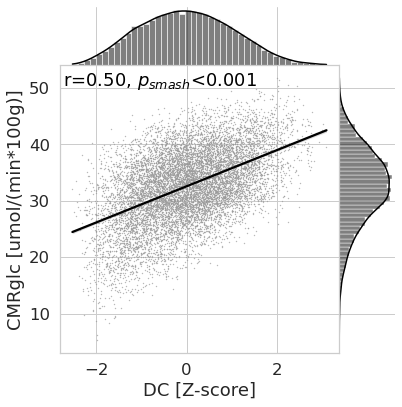

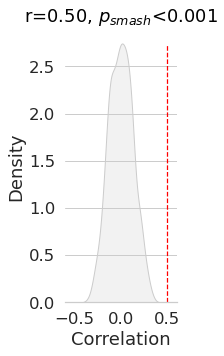

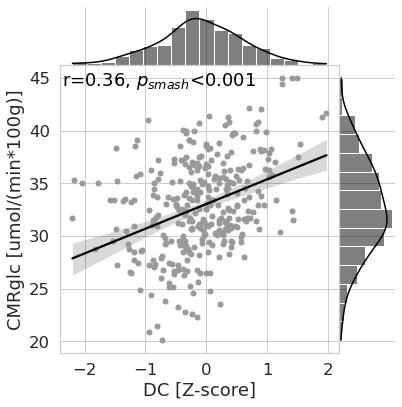

In [69]:
reference_site = 'TUM'
reference_cohort = 'a1'
example_sid = 20
example_ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==cohorts_metadata[reference_site][reference_cohort]['sub_pref'] % example_sid) & (all_ind_vox_vals.cohort==f'{reference_site}.{reference_cohort}')].copy()

## Surface representation
#src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,y_var,'roi_id')[1:],os.path.join(results_dir,'figures',f'fig1A_surf-{y_var}'),
#          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
#          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual CMRglc')
#src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,x_var,'roi_id')[1:],os.path.join(results_dir,'figures',f'fig1A_surf-{x_var}'),
#          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'viridis')(np.arange(0,getattr(plt.cm,'viridis').N))))),
#          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual DC')
#

## Individual voxelwise scatterplot
r_vox_param,_=stats.pearsonr(example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),x_var],example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),y_var])
p_vox_np = nonparp(r_vox_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_vox_np = p_vox_np if p_vox_np>0 else 0.00001
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)

## Smash random distribution
plt.figure(figsize=(2,5))
src.functions.plot_rnd_dist(cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'],
                            r_param,p_np,plt.gca(),xlabel=xlabel,ylabel=ylabel,xlim=(-0.5,0.5),print_text=True)

## Individual ROIwise scatterplot
example_ind_roi_vals = example_ind_vox_vals.groupby('roi_id').median()
r_roi_param,_=stats.pearsonr(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var])
p_roi_np = nonparp(r_roi_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_roi_np = p_roi_np if p_roi_np>0 else 0.00001
g = src.functions.plot_joint(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var],s=25,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_roi_np)


#### 1B. Individual subject analysis

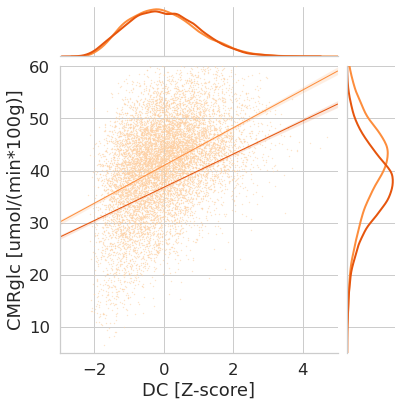

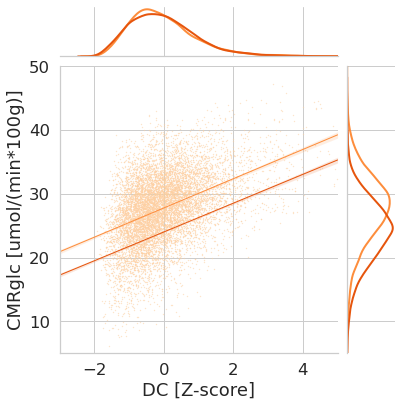

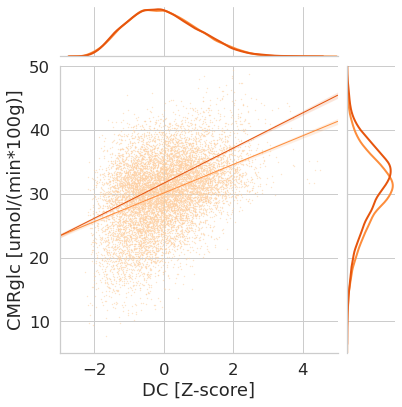

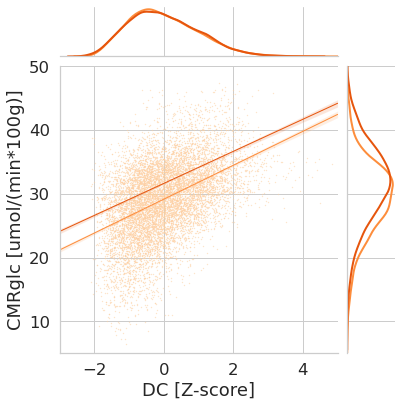

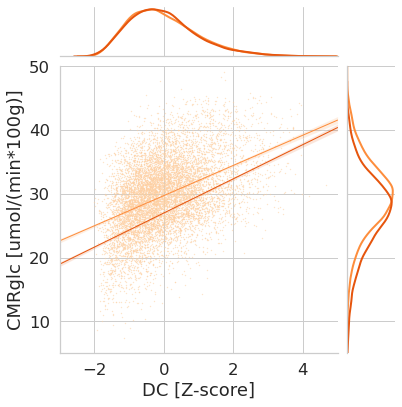

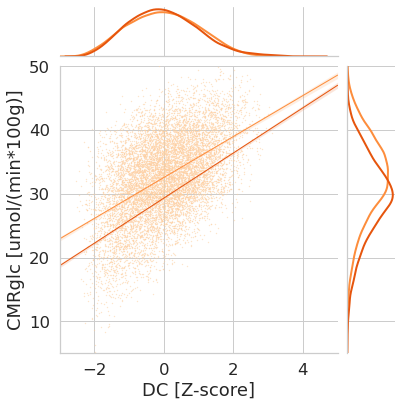

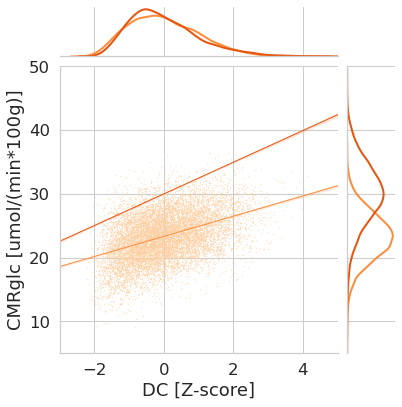

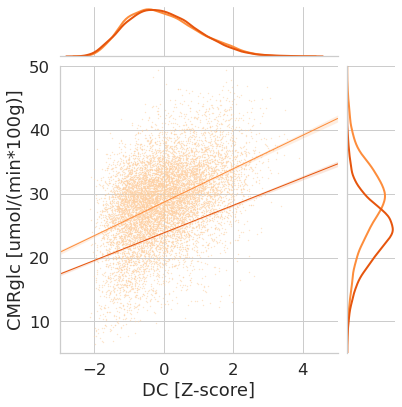

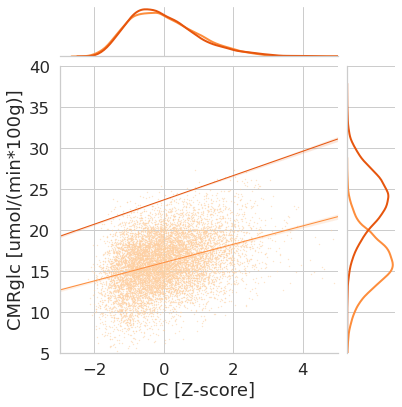

In [37]:
selected_df = all_ind_vox_vals
s = 0.1
selected_site = 'TUM' #options: TUM or VIE
coh0 = 'a1' #options: a1 or b, if the latter (replication cohort TUM), it will ignore the coh1 variable
coh1 = 'a2' #options: a2
selected_site_sids = list(np.unique(cohorts_metadata[selected_site][coh0]['sids']+cohorts_metadata[selected_site][coh1]['sids']))
s1 = f'{selected_site}.{coh0}'
s2 = f'{selected_site}.{coh1}'
scatter_color = plt.cm.tab20c([7]).flatten() if selected_site=='TUM' else plt.cm.tab20c([11]).flatten()#
if((selected_site=='TUM') & (coh0=='b')):
    scatter_color = plt.cm.tab20c([14]).flatten()
    selected_site_sids = cohorts_metadata[selected_site]['b']['sids']
for sid in selected_site_sids:#list(cohorts_metadata[selected_site]['a1']['sids']):
    subj_id = cohorts_metadata[selected_site][coh0]['sub_pref'] % sid
    ylim=(5,50) if sid not in [3,26,33] else (5,60)
    if sid in [26,28,31,34,36]: ylim=(5,40)
    if ((selected_site=='VIE') & (sid not in [4,9,12,14])): ylim=(10,65)
    selected_coh = s1 if sid in cohorts_metadata[selected_site][coh0]['sids'] else s2
    filtered_index = [((selected_df.cohort==selected_coh) & (selected_df.sid==subj_id))]
    smash_dists = [cohorts_metadata[selected_site][selected_coh.split('.')[1]]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
    cohorts_list = [s1,s2]
    color_list = [cohorts_metadata[selected_site][coh0]['color'],cohorts_metadata[selected_site][coh1]['color']]
    if((sid in cohorts_metadata[selected_site][coh1]['sids']) & (sid in cohorts_metadata[selected_site][coh0]['sids'])):
        filtered_index+=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists+=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list,color_list,scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    elif(sid in cohorts_metadata[selected_site][coh1]['sids']):
        filtered_index=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[1:],color_list[1:],scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    else:
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[:1],color_list[:1],scatter_color,
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
 

Text(0.5, 0, 'Pearson correlation')

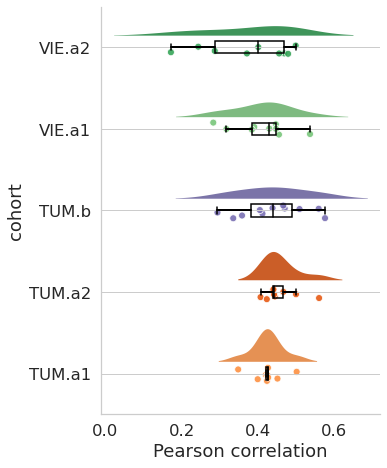

In [67]:
if 'reg_ind_lev_df' not in locals():
    reg_ind_lev_df = pd.DataFrame({},columns=['sid','sex','age','cohort', 'r', 'p','slope'])
    for site in list(cohorts_metadata.keys())[:-1]:
        for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
            cohort = f'{site}.{coh}'
            for sid in cohorts_metadata[site][coh]['sids']:
                subj_id = cohorts_metadata[site][coh]['sub_pref'] % sid
                ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==subj_id) & (all_ind_vox_vals.cohort==cohort)]
                ind_reg_dict = pg.linear_regression(ind_vox_vals[x_var],ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)
                reg_ind_lev_df = reg_ind_lev_df.append({'sid': subj_id,'cohort':cohort, 'r':np.sqrt(ind_reg_dict['r2']), 'p':ind_reg_dict['pval'][1], 'slope':ind_reg_dict['coef'][1]}, ignore_index=True)
                
    reg_ind_lev_df['sex'] = reg_ind_lev_df['sid'].map(sid2sex)
    reg_ind_lev_df['age'] = reg_ind_lev_df['sid'].map(subj_ages)
    reg_ind_lev_df['r']=reg_ind_lev_df['r'].astype('float')
    reg_ind_lev_df['slope']=reg_ind_lev_df['slope'].astype('float')

cohort_order = ['TUM.a1','TUM.a2','TUM.b','VIE.a1','VIE.a2']
coh_colors = {}
for coh in cohort_order:
    coh_colors[coh]=cohorts_metadata[coh.split('.')[0]][coh.split('.')[1]]['color']

f, ax = plt.subplots(figsize=(5,1.5*len(cohort_order))) #7,5
ax=half_violinplot(x='r',y='cohort',data=reg_ind_lev_df,palette=coh_colors,scale = "area", inner = None, orient = 'h',linewidth=0,order=cohort_order[::-1])
ax=sns.stripplot(x='r',y='cohort',data=reg_ind_lev_df,palette=coh_colors,edgecolor="white",size = 7, jitter = 1, zorder = 0, orient = 'h', alpha=0.88,
                         linewidth=0.88, edgecolors='w',order=cohort_order[::-1])
ax=sns.boxplot(x='r',y='cohort',data=reg_ind_lev_df, color = "black", width = .15, zorder = 10, showcaps = True,order=cohort_order[::-1], 
boxprops = {'facecolor':'none', "zorder":10},showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},saturation = 1, orient = 'h')
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(True)
plt.gca().set_xlabel('Pearson correlation')





#### 1C. Group analysis

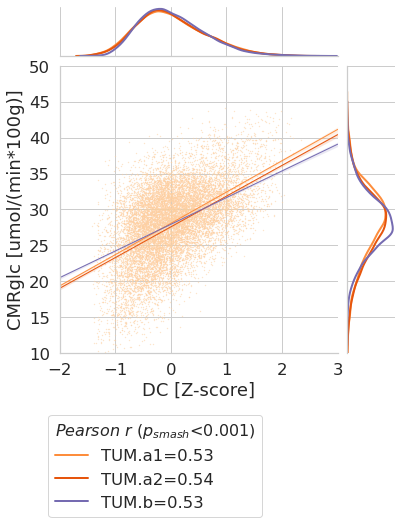

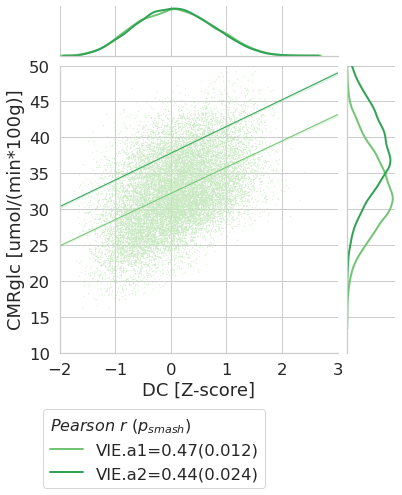

In [68]:
#plot_voxelwise = False
#selected_df = all_ind_vox_vals if plot_voxelwise else all_ind_roi_vals
#s = 0.1 if plot_voxelwise else  25
palette_regplot_index = 5
for site in list(cohorts_metadata.keys())[:-1]:#cohorts_metadata.keys():#
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_vox_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_vox_vals,x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                      plt.cm.tab20c([palette_regplot_index+2]).flatten(),
                      xlabel=xlabel,ylabel=ylabel,xlim=(-2,3),ylim=(10,50),legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4

### Figure 2. Energy density distribution
#### 2A. Calculation

[Text(0.5, 0, 'DC [Z-score]'), Text(0, 0.5, 'residual'), (-19.0, 19.0)]

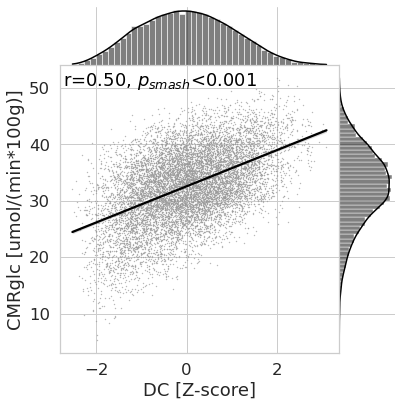

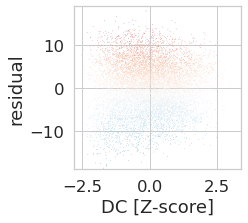

In [80]:
## Individual example
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)
#plt.suptitle(f'{cohorts_metadata[reference_site][reference_cohort]["sub_pref"] % example_sid} {reference_site}.{reference_cohort}')

plt.figure(figsize=(3,3))
example_ind_vox_vals['residual'] = pg.linear_regression(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)['residuals']
sns.scatterplot(x_var,'residual',data=example_ind_vox_vals,s=3*s,legend=False,hue='residual', palette=sel_cm,
                vmin=example_ind_vox_vals.residual.quantile(0.3),vmax=example_ind_vox_vals.residual.quantile(0.7))
plt.gca().set(xlabel=xlabel,ylabel='residual',ylim=(-19,19))


#### 2B. Stability

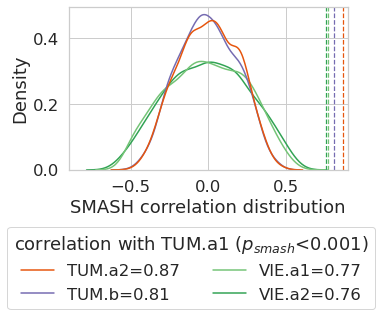

In [94]:
sd_smash_corr_bet_coh_df = pd.DataFrame({})
sd_smash_corr_bet_coh_palette = {}
for cohort in cohort_order[1:]:
    r_param,p_param=stats.pearsonr(all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==f'{reference_site}.{reference_cohort}','energy_density'],
                                   all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==cohort,'energy_density'])
    sd_smash_corr_bet_coh_df[f'{cohort}={r_param:.2f}'] = cohorts_metadata['all']['smash_sd_{}-{}'.format(f'{reference_site}.{reference_cohort}',cohort)]
    sd_smash_corr_bet_coh_palette[f'{cohort}={r_param:.2f}'] = cohorts_metadata[cohort.split('.')[0]][cohort.split('.')[1]]['color']
plt.figure(figsize=(5,3))
g = sns.kdeplot(data=sd_smash_corr_bet_coh_df,palette=sd_smash_corr_bet_coh_palette,legend=True)
legend_handles = g.get_legend().legendHandles #get_legend_handles_labels()
g.get_legend().remove()
plt.legend(handles=legend_handles,title='correlation with TUM.a1 '+r'$(p_{smash}$<0.001)', loc='upper left',ncol=2,bbox_to_anchor=(-0.25,-0.3), labels=list(sd_smash_corr_bet_coh_df.columns))
#plt.legend(legend_handles[0],legend_handles[1],title='correlation with TUM.a1 '+r'$(p_{smash}$<0.001)', loc='upper left', labels=list(sd_smash_corr_bet_coh_df.columns),ncol=2,bbox_to_anchor=(-0.25,-0.3))
plt.gca().set_xlim(-0.9,0.9)
plt.gca().set_xlabel('SMASH correlation distribution')
for ix,col in enumerate(list(sd_smash_corr_bet_coh_df.columns)):
    plt.gca().axvline(float(col.split('=')[1]), 0, 1, color=sd_smash_corr_bet_coh_palette[col], linestyle='dashed', lw=1.25)


#### 2C. Group statistics

<AxesSubplot:>

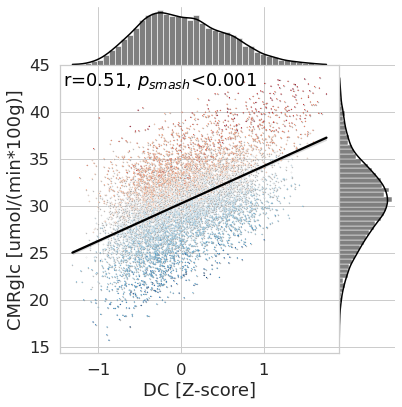

<Figure size 432x288 with 0 Axes>

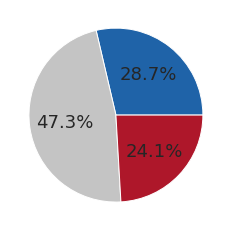

In [111]:
## Average voxel values across subjects from all cohorts using a common group GM mask
avg_vox_vals_with_gx_mask = all_avg_vox_vals_with_gx_mask.groupby('vox_id',as_index=False).median()

## Group linear relationship color coded by energy density 
r_vox_param_all,_=stats.pearsonr(avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),x_var],
                                 avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),y_var])
p_vox_np_all = nonparp(r_vox_param_all, cohorts_metadata['all']['smash_{}-{}'.format(x_var,y_var)])
p_vox_np_all = p_vox_np_all if p_vox_np_all>0 else 0.00001

g = src.functions.plot_joint(avg_vox_vals_with_gx_mask[x_var],avg_vox_vals_with_gx_mask[y_var],s=0.1,robust=False,kdeplot=False,truncate=True,
               xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np_all)
sns.scatterplot(x=x_var, y=y_var, hue='energy_density',data=avg_vox_vals_with_gx_mask,
                linewidth=0,s=1.5,legend=False,palette=sel_cm,ax=g.ax_joint,
                vmin=avg_vox_vals_with_gx_mask.energy_density.quantile(0.25),vmax=avg_vox_vals_with_gx_mask.energy_density.quantile(0.75))

## One sample t-test statistics across subjects
gx_gm_mask_fn = os.path.join(root_dir,'gx_between-cohort_gm-mask_25perc_mni-3mm.nii.gz')
all_sd_fn = os.path.join(root_dir,'all_47subj_ed-z_one-sample-t-test_vox_corrp_tstat1_lt_0.01_mni-3mm.nii.gz')

avg_vox_vals_with_gx_mask['ostt_mask'] = input_data.NiftiMasker(mask_img=gx_gm_mask_fn).fit_transform(all_sd_fn).flatten()[avg_vox_vals_with_gx_mask.vox_id.to_numpy()]
avg_vox_vals_with_gx_mask['ostt_signed'] = avg_vox_vals_with_gx_mask['ostt_mask'] 
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energy_density']<0),'ostt_signed'] = -1
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energy_density']>0),'ostt_signed'] = 1

one_sample_ttest_roi_df = avg_vox_vals_with_gx_mask[['roi_id','ostt_signed']].groupby('roi_id',as_index=False).agg(lambda x: stats.mode(x)[0][0])
one_sample_ttest_roi_df['ostt_mask'] = one_sample_ttest_roi_df['ostt_signed']
one_sample_ttest_roi_df.loc[one_sample_ttest_roi_df['ostt_mask']!=0,'ostt_mask']=1
plt.figure()
one_sample_ttest_roi_df.groupby('ostt_signed').count().plot(kind='pie', y='roi_id',legend=False,colors=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0),shadow=False,autopct='%1.1f%%',xlabel='',ylabel='',labels=['','',''],startangle=0)



#### 2D. Subject and network distribution

<AxesSubplot:>

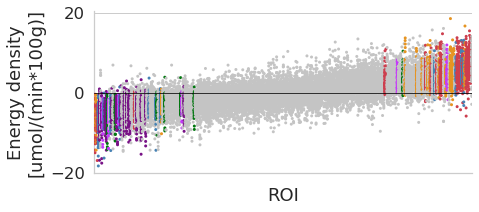

<Figure size 432x288 with 0 Axes>

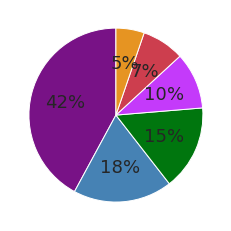

<Figure size 432x288 with 0 Axes>

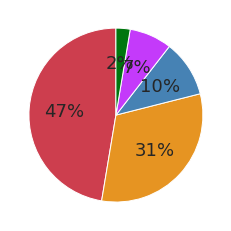

In [139]:
all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()
all_ind_roi_vals['nw'] = all_ind_roi_vals['roi_id'].map(atlas_dict['roi2network'])
all_ind_roi_vals['nw_consistent_rois'] = all_ind_roi_vals['nw']
all_ind_roi_vals['ed_sign_consistent_rois'] = 0
for roi_id in all_ind_roi_vals.roi_id.unique():
    if np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()>0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ed_sign_consistent_rois'] = -1
    elif np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()<0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ed_sign_consistent_rois'] = 1
    else:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'nw_consistent_rois'] = 'None'
    #if ~((np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()>0)<=2) | (np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()<0)<=2)):
    #    all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'nw_consistent_rois'] = 'None'

nw_consistent_rois_palette = atlas_dict['nw2color']
nw_consistent_rois_palette['None'] = gray_c

roi_ids_order = all_ind_roi_vals.groupby('roi_id',as_index=False).median().sort_values(by='energy_density',ignore_index=True).roi_id.to_list()
### To test the plot with less ROIS: all_ind_roi_vals[all_ind_roi_vals.roi_id.isin(all_ind_roi_vals.roi_id.unique()[::10])]
g = sns.catplot(x='roi_id', y='energy_density', data=all_ind_roi_vals,height=3.5,aspect=2,hue='nw_consistent_rois',
                palette=nw_consistent_rois_palette,order=roi_ids_order,legend=False,s=3)
g.set(xticklabels=[])
plt.gca().set_xlabel('ROI')
plt.gca().set_ylabel('Energy density\n[umol/(min*100g)]')
plt.gca().axhline(0, 0, 1, color='k', lw=0.75,zorder=10)

avg_consistent_roi_vals = all_ind_roi_vals[all_ind_roi_vals.nw_consistent_rois!='None']
plt.figure()
avg_consistent_neg_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ed_sign_consistent_rois<0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_neg_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',startangle=90,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_neg_roi_vals.index.tolist()])
plt.figure()
avg_consistent_pos_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ed_sign_consistent_rois>0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_pos_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',startangle=90,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_pos_roi_vals.index.tolist()])


#low_cons_df =  mm_roi_df_cp_gx[mm_roi_df_cp_gx['conj_consistent']<0].groupby('nw').count().sort_values(by='roi_id', ascending=False)
#high_cons_df = mm_roi_df_cp_gx[mm_roi_df_cp_gx['conj_consistent']>0].groupby('nw').count().sort_values(by='roi_id', ascending=False)
#
#
#plt.figure()
#low_cons_df.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',labels=['','','','','',''],startangle=90,colors=[atlas_dict['nw2color'][cx] for cx in low_cons_df.index.tolist()])
#plt.figure()
#high_cons_df.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',labels=['','','','','',''],startangle=90,colors=[atlas_dict['nw2color'][cx] for cx in high_cons_df.index.tolist()])



### Figure 3. Energy density distribution relates to human cognitive functions and cortical evolution
#### 3A. Cognitive functions

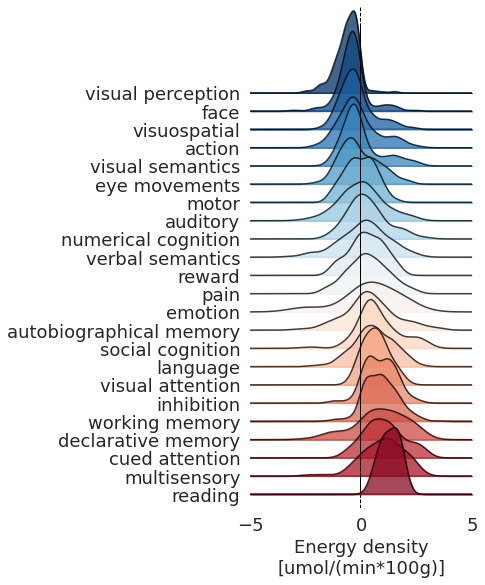

In [159]:
import joypy
neurosynth_masks_df = pd.read_csv(os.path.join(root_dir,f'gx_neurosynth-masked_ed-median_cohorts-all_vox_nsubj-{total_n_subj}_{conn_metric}-{dc_type}_v1.0.csv'))
neurosynth_order = neurosynth_masks_df[neurosynth_masks_df.energy_density!=0.0].groupby('domain', as_index=False).median().sort_values(by='energy_density',ignore_index=True)
neurosynth_order['sorted_domain'] = neurosynth_order.index.astype(str).str.zfill(2)+'-'+neurosynth_order.domain
sorted_domain_map = dict(zip(neurosynth_order['domain'],neurosynth_order['sorted_domain']))
neurosynth_masks_df['sorted_domain'] = neurosynth_masks_df['domain'].map(sorted_domain_map)
joypy.joyplot(
    neurosynth_masks_df,#[neurosynth_masks_df.signal_density!=0.0],#[neurosynth_masks_df.inefficiency!=0.0],
    by="sorted_domain", 
    column="energy_density",#figsize=(5,8),
    colormap=plt.cm.RdBu_r,
    alpha=0.75,
    figsize=(7,8),
    labels=list(neurosynth_masks_df.sort_values(by='sorted_domain',ignore_index=True)['domain'].unique()),
    #fade=True
)#,overlap=3)#,x_range=[0,110])
plt.gca().set_xlim([-5,5])
plt.gca().set_xlabel('Energy density\n[umol/(min*100g)]')
for axx in plt.gcf().get_axes()[:-1]:
    axx.axvline(0, 0, 1, color='k', linestyle='dashed', lw=1)#,zorder=7)

#### 3B. Comparative neuroenergetics

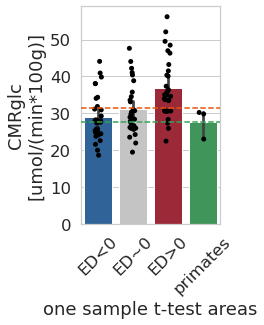

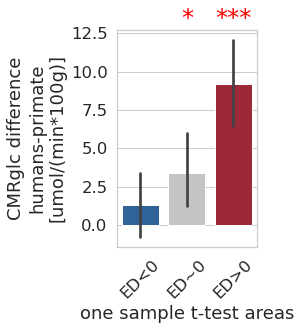

In [175]:
plt.figure(figsize=(2.5,4))
sns.barplot(x="ostt_signed", y=pet_metric, data=all_ind_vox_vals.groupby(['sid','ostt_signed'],as_index=False).median(),hue="ostt_signed",dodge=False,
            palette=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:],plt.cm.tab20c(range(20))[8][np.newaxis,:]),axis=0))
plt.gca().get_legend().remove()
sns.stripplot(x="ostt_signed", y=pet_metric, data=all_ind_vox_vals.groupby(['sid','ostt_signed'],as_index=False).median(),color='k')
plt.gca().set_ylabel('\n'.join(ylabel.split(' ')))
plt.gca().set_xticklabels(['ED<0', 'ED~0', 'ED>0', 'primates'])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=45)
plt.gca().set_xlabel('one sample t-test areas')
plt.gca().axhline(all_ind_vox_vals.loc[all_ind_vox_vals.ostt_signed==2,y_var].mean(), 0, 1, linestyle='dashed', color=plt.cm.tab20c(range(20))[8], lw=1.5,zorder=10)
plt.gca().axhline(all_ind_vox_vals.groupby(['roi_id'],as_index=False).median()[pet_metric].mean(), 0, 1, linestyle='dashed', color=plt.cm.tab20c(range(20))[4], lw=1.5,zorder=10)

plt.figure(figsize=(2.5,4))
apes_diff_sign_df = all_ind_vox_vals[(all_ind_vox_vals.ostt_signed!=2)].groupby(['sid','ostt_signed'],as_index=False).median()
sns.barplot(x="ostt_signed", y=pet_metric+'_diff_apes', data=apes_diff_sign_df,hue="ostt_signed",dodge=False,
            palette=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0))
plt.gca().get_legend().remove()
plt.gca().set(xlabel='one sample t-test areas', ylabel='CMRglc difference\nhumans-primate\n[umol/(min*100g)]', xticklabels=['ED<0', 'ED~0', 'ED>0'])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=45)

apes_diff_sign = []
for ix in range(-1,2):
    apes_diff_sign += [stats.ttest_1samp(apes_diff_sign_df[apes_diff_sign_df.ostt_signed==ix].cmrglc_diff_apes.to_numpy(), 0)[1]]
apes_diff_sign = pg.multicomp(np.array(apes_diff_sign),method='bonf')[1]
for ix in range(len(apes_diff_sign_df.ostt_signed.unique())):
    if apes_diff_sign[ix]<0.055:
        sign_text = '***' if apes_diff_sign[ix]<0.0001 else '*'
        plt.gca().text(ix, plt.gca().get_ylim()[1]-0.1, sign_text, ha='center', va='bottom', color='r', size=24)


#### 3C. Allometric brain expansion

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]
[ 0.87546246 -2.84928267]


Text(0.18134752642363305, -10.759534282, 'energy_density ~  -2.85 + expansion^0.88')

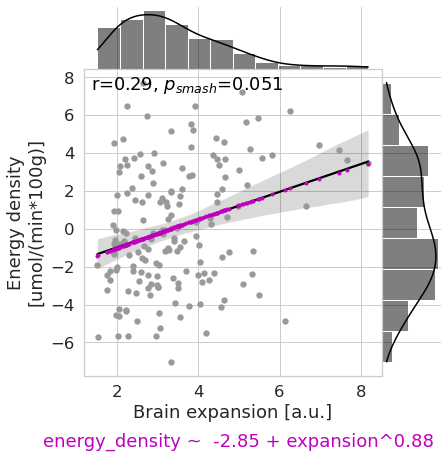

In [231]:
chimp2human_expansion = []
for _, h in enumerate(['lh', 'rh']):
    chimp2human_expansion = np.append(chimp2human_expansion, nib.load(os.path.join(root_dir,'external',f'Wei2019/{h}.32k.chimp2humanF.smoothed15.shape.gii')).darrays[0].data)
chimp2human_expansion = surface_to_parcel(chimp2human_expansion,'glasser_360_conte69')[1:]
avg_roi_ed_vals= src.functions.metric2mmp(all_avg_roi_vals,'energy_density','roi_id')

src.functions.smash_comp(chimp2human_expansion[:180],avg_roi_ed_vals,None,y_nii_fn=os.path.join(results_dir,'figures',f'fig3C_allometric_ed-chimp2humanexpansion.png'),
           l=5,u=95,n_mad='min',ylabel='Energy density\n[umol/(min*100g)]', xlabel='Brain expansion [a.u.]',p_uthr=1,plot=True,
           cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=False,plot_surface=False,x_surr_corrs=cohorts_metadata['all']['smash_sd_{}-{}'.format(x_var,y_var)],
          )

valid_ind = src.functions.valid_data_index(chimp2human_expansion[:180],avg_roi_ed_vals,n_mad='min')
allometric_fit_params,_ = curve_fit(src.functions.allometric_fit, chimp2human_expansion[:180][valid_ind],avg_roi_ed_vals[valid_ind])
plt.gca().plot(chimp2human_expansion[:180][valid_ind],allometric_fit_params[1] + chimp2human_expansion[:180][valid_ind]**allometric_fit_params[0],'.m')#[0.90196078, 0.33333333, 0.05098039])

allometric_model = allometric_model = r'energy_density ~  %0.2f + expansion^%0.2f' % (allometric_fit_params[1],allometric_fit_params[0])
plt.gca().text(plt.gca().get_xlim()[0]-1,plt.gca().get_ylim()[0]-3, allometric_model, ha='left',va='top', color='m')

### Figure 4. Layer specific cellular organization of energy dense regions
#### 4A. Histological cell density across cortical layers 

[Text(0.5, 0, 'staining\nintensity')]

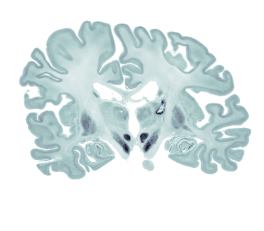

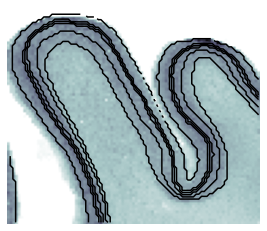

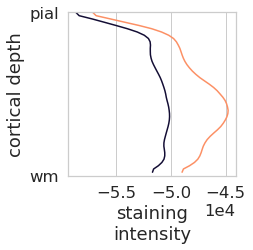

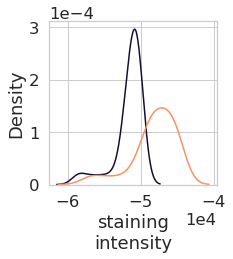

In [247]:
## Ultra-high resolution histological slice from the BigBrain atlas
bb_vol = nib.load(os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','full8_200um_optbal.nii.gz'))
bb_layers = nib.load(os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','segmentation_200um.nii.gz'))
section = 385 # seleceted arbitrarily
bb_layers_section=bb_layers.dataobj[section]
bb_histo_section = bb_vol.dataobj[section]
plt.imshow(np.flipud(bb_histo_section),cmap='bone')
plt.gca().axis('off')
plt.figure()
plt.imshow(np.flipud(bb_histo_section[480:560,297:390]),cmap='bone') # seleceted arbitrarily
plt.gca().axis('off')
bb_layers_section[bb_layers_section<1]=np.nan
bb_layers_section[np.isin(bb_layers_section,[2,3,5,6])]=np.nan
plt.gca().contour(np.flipud(bb_layers_section[480:560,297:390]), colors='k')

## Big brain upsample to 50 cortical layers between pial and white matter surfaces
bb_profiles = np.loadtxt(os.path.join(root_dir,'external','BigBrainWarp','tpl-fs_LR_den-32k_desc-profiles.txt'),delimiter=',')
bb_profiles_inv = bb_profiles * -1
bb_profiles_inv_all = surface_to_parcel(np.sum(bb_profiles_inv,axis=0),'glasser_360_conte69')[1:]
bbl_roi = np.array([])
for bb_layer in bb_profiles_inv:
    bbl_roi = np.append(bbl_roi,surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:],axis=0) if bbl_roi.shape[0]>0 else surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:]
bbl_roi_mean = np.mean(bbl_roi,axis=0)
bbl_roi_skew = []
for bbp in bbl_roi.T:
    bbl_roi_skew += [stats.skew(bbp, bias=True)]
bbl_roi_skew = np.array(bbl_roi_skew)

##example datapoints selected visually from the scatter plot
lskew = np.where((bbl_roi_skew[:180]>-2.25) & (bbl_roi_skew[:180]<-2.2) & (avg_roi_ed_vals>5))[0][0]
hskew=np.where((bbl_roi_skew[:180]<-1.38) & (bbl_roi_skew[:180]>-1.4) & (avg_roi_ed_vals<0) & (avg_roi_ed_vals>-0.3))[0][0]

plt.figure(figsize=(3,3))
plt.plot(bbl_roi[:,lskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[24],label='left')
plt.plot(bbl_roi[:,hskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[196],label='right') #231
plt.gca().set(ylim=(0,50),yticks=(0,50),yticklabels=['wm','pial'],xlabel='staining\nintensity',ylabel='cortical depth')
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))

plt.figure(figsize=(3,3))
sns.kdeplot(bbl_roi[:,lskew],color=getattr(plt.cm,'magma')(range(256))[24],label='left')
sns.kdeplot(bbl_roi[:,hskew],color=getattr(plt.cm,'magma')(range(256))[196],label='right')#231
plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().set(xlabel='staining\nintensity')


#### 4B. Energy density relationship with cell density in infragranular layers 

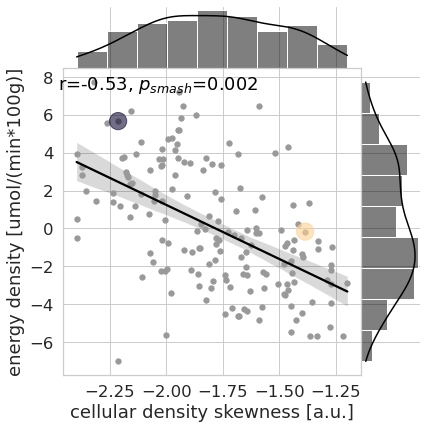

In [242]:
src.functions.smash_comp(bbl_roi_skew[:180],avg_roi_ed_vals,None,y_nii_fn=os.path.join(results_dir,'figures',f'fig4B_bb-skew_vs_ed.png'),
                         ylabel='energy density [umol/(min*100g)]', xlabel='cellular density skewness [a.u.]',
                         l=5,u=95,n_mad='min',p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False,
                         x_surr_corrs=cohorts_metadata['all']['smash_bb-skew_{}-{}'.format(x_var,y_var)])
plt.gca().scatter(bbl_roi_skew[[lskew,hskew]],avg_roi_ed_vals[[lskew,hskew]],s=300, alpha=0.6,
                  c=np.concatenate((getattr(plt.cm,'magma')(range(256))[24][np.newaxis,:],getattr(plt.cm,'magma')(range(256))[231][np.newaxis,:]),axis=0))
#plt.figure()
#plot_surf(np.array(bbl_roi_skew[:180]),os.path.join(img_dir,'bb_skew'),colorbar=True,cmap='magma',fig_title='BB skewness',vlow=5,vhigh=95)

#### 4C. Energy density relationship with transcription levels for signaling

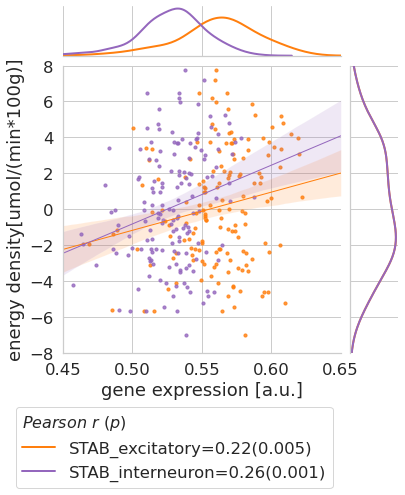

<Figure size 432x288 with 0 Axes>

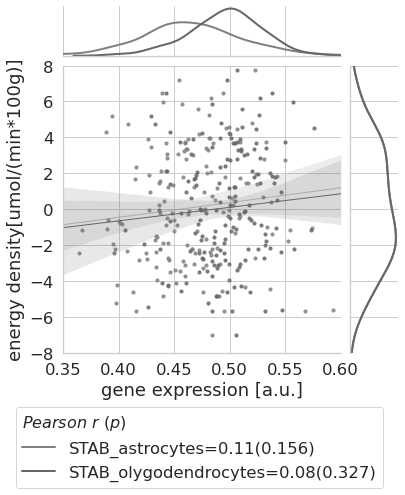

In [272]:
ahba_gene_expression = fetch_ahba(os.path.join(root_dir,'external','AHBA','allgenes_stable_r0.2_glasser_360.csv'))
stab_genesets = ['STAB_excitatory','STAB_interneuron','STAB_astrocytes','STAB_olygodendrocytes']
stab_geneset_clusters = {}
stab_geneset_clusters['STAB_excitatory'] = ['ExN1_4','ExN1a','ExN1b','ExN1c','ExN2','ExN3','ExN4','ExN5','ExN6a','ExN6b','ExN8','ExN9','ExN10','ExN11']
stab_geneset_clusters['STAB_interneuron'] = ['InN1a','InN1b','InN3','InN4a','InN4b','InN4_5','InN5','InN5_6','InN6','InN7_8']
stab_geneset_clusters['STAB_astrocytes'] = ['Astro1','Astro2','Astro3','Astro4']
stab_geneset_clusters['STAB_olygodendrocytes'] = ['Olig1','Olig3','Olig4','NPC']
stab_gene_expression_df = pd.DataFrame({})
for geneset in stab_genesets:
    stab_genesets_clusters_gene_ids = []
    for geneset_cluster in stab_geneset_clusters[geneset]:
        stab_genesets_clusters_gene_ids += pd.read_csv(os.path.join(root_dir,'external','STAB2021',f'{geneset_cluster}.tsv'),sep='\t')['symbol'].to_list()
    stab_gene_expression_df = pd.concat([stab_gene_expression_df,
                                         pd.DataFrame({'energy_density':avg_roi_ed_vals,
                                                       'gene_expression':src.functions.gx_gene_exp(ahba_gene_expression,stab_genesets_clusters_gene_ids,mmp_n,agg_func='nanmean')[:180],
                                                       'type':geneset})],
                                        ignore_index=True)
                
stab_gene_expression_df = stab_gene_expression_df[(stab_gene_expression_df.energy_density>stab_gene_expression_df.energy_density.min()) & (stab_gene_expression_df.gene_expression>stab_gene_expression_df.gene_expression.min())]        
    
stab_filter_labels = ['STAB_excitatory','STAB_interneuron']
stab_palette_regplot = [sns.color_palette()[1],sns.color_palette()[4]]
xlab='gene_expression'
ylab='energy_density'
stab_filtered_index_lists=[]
for stab_filt in stab_filter_labels:
    stab_filtered_index_lists+=[stab_gene_expression_df.type==stab_filt]
src.functions.multiple_joinplot(stab_gene_expression_df,xlab,ylab,stab_filtered_index_lists,[],stab_filter_labels,stab_palette_regplot,[],
                  xlabel='gene expression [a.u.]',ylabel='energy density[umol/(min*100g)]',xlim=(0.45,0.65),ylim=(-8,8),s=10)
plt.figure()
stab_filter_labels = ['STAB_astrocytes','STAB_olygodendrocytes']
stab_palette_regplot = [(0.5,0.5,0.5,0.5),(0.4,0.4,0.4,1)]
stab_filtered_index_lists=[]
for stab_filt in stab_filter_labels:
    stab_filtered_index_lists+=[stab_gene_expression_df.type==stab_filt]
src.functions.multiple_joinplot(stab_gene_expression_df,xlab,ylab,stab_filtered_index_lists,[],stab_filter_labels,stab_palette_regplot,[],
                  xlabel='gene expression [a.u.]',ylabel='energy density[umol/(min*100g)]',xlim=(0.35,0.60),ylim=(-8,8),s=10)


### Figure 5. Higher rate of neuromodulation in energy dense regions
#### 5A. Significant correlations between energy density and gene expression of brain specific genes

<AxesSubplot:>

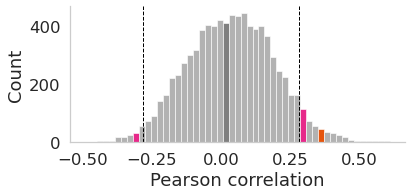

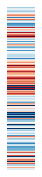

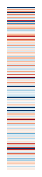

In [279]:
corr_ed_gexp = pd.DataFrame(columns=['gene','r','p'])
for gen in ahba_gene_expression.columns[1:]:
    gene_expression = ahba_gene_expression[gen].to_numpy()[:180]
    gene_expression[np.isnan(gene_expression)]=np.min(gene_expression)-1 if np.min(gene_expression)<0 else 0
    r_ed_gexp_p, p_ed_gexp_p = src.functions.corr_wo_outliers(avg_roi_ed_vals,gene_expression,n_mad=3.5)
    corr_ed_gexp = corr_ed_gexp.append({'gene':gen,'r':r_ed_gexp_p,'p':p_ed_gexp_p}, ignore_index=True)

_,corr_ed_gexp['p_fdr'] = pg.multicomp(corr_ed_gexp['p'].to_numpy().astype(np.float32),method='fdr_bh')

plt.figure(figsize=(6,2.5))
sns.histplot(data=corr_ed_gexp, x="r",color=(0.6,0.6,0.6))
## Statsitical significance thresholds
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r<0)].r.max(), 0, 1, color='k', linestyle='dashed', lw=1)
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r>0)].r.min(), 0, 1, color='k', linestyle='dashed', lw=1)

hist_data = np.histogram_bin_edges(corr_ed_gexp.r.to_numpy(), bins=len(plt.gca().patches))
sel_genes_colors = [plt.cm.Dark2(range(8))[3].flatten(),plt.cm.Dark2(range(8))[3].flatten(),plt.cm.tab20c([4]).flatten()]
genes_with_pet_available = np.array(['OPRM1','HTR4','CHRNA4']) # derived from figure 5E, buzt used here to don't duplicate the histogram there
for cix,sel_gene in enumerate(genes_with_pet_available):
    patch_index = (np.abs((hist_data-corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.gene==sel_gene)].r.item()))).argmin()
    plt.gca().patches[patch_index].set_facecolor(sel_genes_colors[cix])
patch_index = (np.abs((hist_data-0))).argmin() #0 correlation gene
plt.gca().patches[patch_index].set_facecolor('gray')
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.gca().set_xlabel('Pearson correlation')

gene_exp_null_corr = ahba_gene_expression[corr_ed_gexp[(corr_ed_gexp.r>0) & (corr_ed_gexp.r<=0.000011)].gene.item()].to_numpy()[:180] # gen non-correlated with the energy density chosen arbitrary
gene_exp_null_corr[np.isnan(gene_exp_null_corr)]=np.min(gene_exp_null_corr)-1 if np.min(gene_exp_null_corr)<0 else 0
plt.figure(figsize=(0.5,3))
sns.heatmap(avg_roi_ed_vals[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)
plt.figure(figsize=(0.5,3))
sns.heatmap(gene_exp_null_corr[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)

#plt.figure()
#plot_surf(gene_exp_null_corr,os.path.join(img_dir,corr_ed_gen[(corr_ed_gen.r>0) & (corr_ed_gen.r<=0.000011)].gene.item()),colorbar=False,cmap=ListedColormap(extended_cm),vlow=5,vhigh=95)#
#plt.figure()
#plot_surf(ed_180rois,os.path.join(img_dir,'avg_sign_density_4coh'),colorbar=False,cmap=ListedColormap(extended_cm),vlow=5,vhigh=95)



#### 5B. Gene ontology (GO): cellular components

Text(0.5, 1.0, '$\\bf{Enrichment}$ Gene ontology - cellular component')

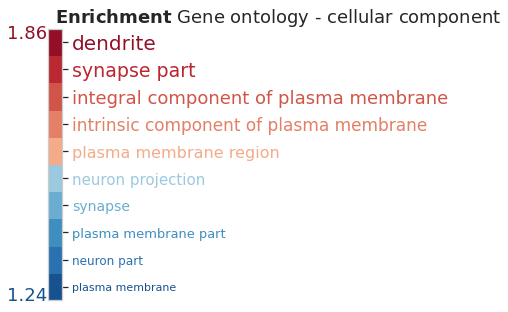

In [283]:
go_cell_comps = pd.read_csv(os.path.join(root_dir,'CompEnrichment_SD_AHBA_fdr0005_all_bgGTEx_Allsign.txt'),sep='\t')
go_cell_comps = go_cell_comps.sort_values(by='Enrichment',ignore_index=True) # Highest enrichment goes on the top
go_cell_comps['-log10(p_FDR)'] = -np.log10(go_cell_comps['FDR q-value'])

cix = 17
clrs_bar = []
for ix in range(go_cell_comps.shape[0]):
    clrs_bar+=[extended_cm[cix]]
    cix=cix+16 if cix!=81 else cix+16*6  
fig, ax = plt.subplots(figsize=(0.25,5))
cb = colorbar.ColorbarBase(ax, cmap=ListedColormap(clrs_bar), orientation = 'vertical',ticks=np.arange(0.05,1,0.1))
go_cell_comps_tickl = go_cell_comps.Description.to_list()
cb.ax.set_yticklabels(go_cell_comps_tickl) 
for yix,ytickl in enumerate(cb.ax.get_yticklabels()):
    ytickl.set_color(clrs_bar[yix])
    ytickl.set_fontsize(10+yix+1)
cb.ax.text(-1.5, 0.05, go_cell_comps.loc[0,"Enrichment"],color=clrs_bar[0], transform=cb.ax.transAxes, va='top', ha='center')
cb.ax.text(-1.5, 0.95, go_cell_comps.loc[go_cell_comps.shape[0]-1,"Enrichment"],color=clrs_bar[-1], transform=cb.ax.transAxes, va='bottom', ha='center')
cb.ax.set_title( r'$\bf{Enrichment}$ Gene ontology - cellular component',fontdict={'horizontalalignment':'left'})


In [ ]:
go_genes = pd.read_excel(os.path.join(root_dir,'SD_AHBA_fdr0005_GTExbrainBG_GO_significant_genes.xlsx'),engine='openpyxl',usecols='A:I',nrows=70)
go_genes_summary = go_genes.groupby(['gene_type','gene_type_subcategory'],as_index=False).count()#['gene']
total_genes = go_genes_summary.gene.sum()
go_genes_pie_data = np.concatenate((go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_numpy()[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0])[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='others'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0,0])[np.newaxis,:]
                                    ),axis=0)

go_genes_pie_data = np.round(100*go_genes_pie_data/total_genes)
go_genes_pie_labels = go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[1] = go_genes_pie_labels[0] #only valid because both categories have the same value
go_genes_pie_labels[0] = '' #others
## to make narrow the plot
go_genes_pie_labels[1] = 'ligang-gated\nreceptor'
go_genes_pie_labels[2] = 'voltage gated\nion channels'
go_genes_pie_labels[3] = 'G-protein\ncoupled receptor'
go_genes_pie_labels += go_genes_summary.loc[(gor_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[4] = '' #G protein duplicated
go_genes_pie_labels += ['','','','','','']

fig, ax = plt.subplots(figsize=(5,5))
wd0,t0 = ax.pie(gor_genes_pie_data.flatten(), radius=1,
    #list(gor_genes_pie_data.flatten()[:3])+[gor_genes_pie_data[0,3]+gor_genes_pie_data[1,0]]+list(gor_genes_pie_data.flatten()[5:]), radius=1, 
                colors=np.concatenate((np.array(list(plt.cm.tab20c(range(20))[7][:3])+[0.5])[np.newaxis,:],plt.cm.tab20c(range(20))[np.arange(7,5,-1)],
                                       np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],
                                       plt.cm.tab20c(range(20))[14:16],np.concatenate((plt.cm.tab20c(range(20))[15][:3],[0.5]))[np.newaxis,:],
                                       np.repeat(np.array([plt.cm.tab20c(range(20))[16]]),4,axis=0)),axis=0),
                labels=gor_genes_pie_labels,wedgeprops=dict(width=0.3, edgecolor='w'),labeldistance=1.1)#,textprops={'ha':'right'}
                #labels=gor_genes_pie_labels[:4]+gor_genes_pie_labels[5:]
                #for distiniguishing between G-protein subcategories
                #gor_genes_pie_data.flatten(),
                #colors=np.concatenate((np.array(list(plt.cm.tab20c(range(20))[7][:3])+[0.5])[np.newaxis,:],plt.cm.tab20c(range(20))[np.arange(7,4,-1)],
                #                       plt.cm.tab20c(range(20))[13:16],np.concatenate((plt.cm.tab20c(range(20))[15][:3],[0.5]))[np.newaxis,:],
                #                       np.repeat(np.array([plt.cm.tab20c(range(20))[16]]),4,axis=0)),axis=0),
                #labels=gor_genes_pie_labels,
                
#t0[3].set_color(plt.cm.Set2(range(8))[3])
wd,_,_ =ax.pie(gor_genes_pie_data.sum(axis=1), radius=0.7, colors=plt.cm.tab20c(range(20))[[4,12,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'),autopct='%d%%',textprops=dict(color="w"),pctdistance=0.75)
wd1,_ =ax.pie(np.array([np.sum(gor_genes_pie_data[:2]),np.sum(gor_genes_pie_data[-1])]), radius=0.4, colors=plt.cm.tab20c(range(20))[[8,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'))
#wd2,_ =ax.pie(np.array([np.sum(gor_genes_pie_data[0,:-1]),gor_genes_pie_data[0,-1]+gor_genes_pie_data[1,0],gor_genes_pie_data[1,1],gor_genes_pie_data[2,0]]),
#                radius=1, colors=['w',plt.cm.Dark2(range(8))[3],'w'],wedgeprops=dict(width=0.025))
ax.set(aspect="equal")
ax.legend([wd1[0]]+wd, ['signal transduction','cell-cell signaling','cellular signaling','others'],
          loc='lower left', ncol=2, bbox_to_anchor=(-0.4, -0.225))

### bin

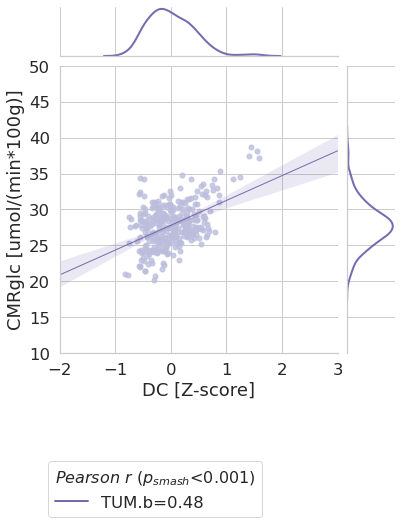

In [12]:
#SHow that the relationship is linear
palette_regplot_index = 12 #12 for tum.b 5 for TUM.a1
for site in list(cohorts_metadata.keys())[:1]:#[:-1]:#cohorts_metadata.keys():#
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())[-1:]):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_roi_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_roi_vals,x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                      plt.cm.tab20c([palette_regplot_index+2]).flatten(),s=25,
                      xlabel=xlabel,ylabel=ylabel,xlim=(-2,3),ylim=(10,50),legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4

#### Energy density across cohorts

In [ ]:
exp_thr = np.log(external_datasets['expansion']['data'][:180]) if expresion_log else external_datasets['expansion']['data'][:180]
for site in list(cohorts_metadata.keys()):#[:-1]:#cohorts_metadata.keys():#
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_vox_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        plot_surf(metric2mmp(all_avg_vox_vals[all_avg_vox_vals.cohort==cohort],'signal_density','roi_id'),
                  os.path.join(root_dir,project_id,session,'pet','{}.{}_{}'.format(site,coh,y_var)),
                  cmap=ListedColormap(np.concatenate((np.array([[0.5,0.5,0.5,1.0]]),getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
                  colorbar=True,vlow=10,vhigh=90,fig_title='{} {}.{}'.format(y_var,site,coh))
        
        sd_180rois = 
    smash_comp(sd_180rois,exp_thr,lh_dist_full,y_nii_fn=os.path.join(img_dir,'expansion_wei2019.png'),l=5,u=95,n_mad='min',
                   xlabel='Signal density\n[umol/(min*100g)]' if y_var==pet_metric else 'Signal density', ylabel='Brain expansion',
                   p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=True,plot_surface=True,
                   x_surr_corrs=cohorts_metadata[site][coh]['smash_sd_{}-{}'.format(x_var,y_var)])

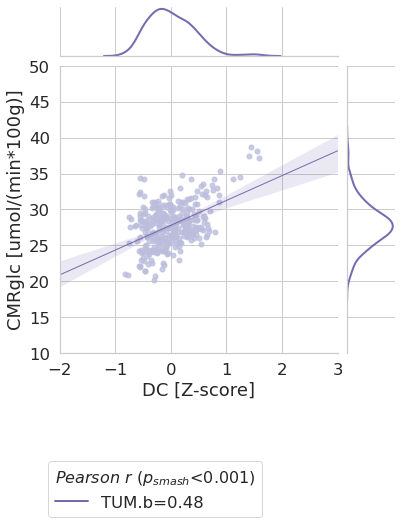

In [12]:
#SHow that the relationship is linear
palette_regplot_index = 12 #12 for tum.b 5 for TUM.a1
for site in list(cohorts_metadata.keys())[:1]:#[:-1]:#cohorts_metadata.keys():#
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())[-1:]):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_roi_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_roi_vals,x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                      plt.cm.tab20c([palette_regplot_index+2]).flatten(),s=25,
                      xlabel=xlabel,ylabel=ylabel,xlim=(-2,3),ylim=(10,50),legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4

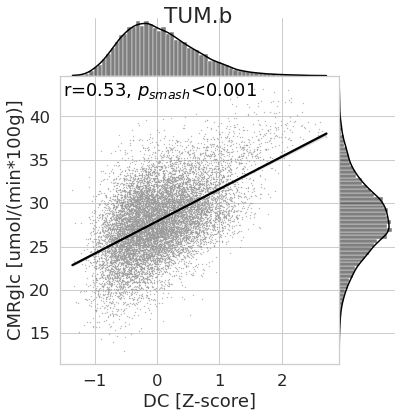

In [ ]:
#list(cohorts_metadata.keys())[:-1] when site ='all' is already included
for site in list(cohorts_metadata.keys())[:1]:#[:-1]:#cohorts_metadata.keys():#list(cohorts_metadata.keys())[:1]:#
    for coh in list(cohorts_metadata[site].keys())[:1]:#cohorts_metadata[site].keys():#list(cohorts_metadata[site].keys())[:1]:#
        project_id = cohorts_metadata[site][coh]['project_id']
        session = cohorts_metadata[site][coh]['session']
        version = cohorts_metadata[site][coh]['version']
        total_n_subj += cohorts_metadata[site][coh]['n_subj']
        cpac_dir = os.path.join(root_dir,project_id,fc_res_label,session)
        ses_dir = os.path.join(root_dir,project_id,session)
        if all_avg_vox_vals.size==0:
            cpac_dir = os.path.join('../../../',project_id,fc_res_label,session)
            ses_dir = os.path.join('../../../',project_id,session)
            gm_mask_pref = 'mean_'+session+'_segment_seg_1_'+thr_i+'_mni-'+vol_res+'_'+atlas_suf+version
            gx_gm_mask_fn = os.path.join(cpac_dir,gm_mask_pref+'.nii.gz')
            pet_fn = os.path.join(ses_dir,'all_'+session+'_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+'.nii.gz')
            if conn_metric=='degree':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_centrality_{}_mnireg-{}_gm-{}'.format(dc_type,vol_res,thr_i)+freq_band+GSR+dyn_wc+sthr_suf+smooth_suf+z_suff+version+'.nii.gz')# 
            elif conn_metric=='shannon_entropy':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_bits{}_mni-{}{}.nii.gz'.format(smooth_suf,vol_res,version))
            elif conn_metric=='alff':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_mnireg-{}_gm-{}'.format(vol_res,thr_i)+z_suff+version+freq_band+'.nii.gz')
            sd_fn = os.path.join(ses_dir,'all_'+session+'_signden_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+sthr_suf+'.nii.gz')
            rois_fn = os.path.join(cpac_dir,gm_mask_pref+'_rois.nii.gz')
            avg_vox_vals_dict = src.functions.read_mask_nii(gx_gm_mask_fn,roi_labels=['roi_id'],z_score=True,cmrglc=pet_fn,degree=fmri_fn,roi_id=rois_fn)#,signal_density=sd_fn
            avg_vox_vals_dict['roi_id'][avg_vox_vals_dict['roi_id']>180] = avg_vox_vals_dict['roi_id'][avg_vox_vals_dict['roi_id']>180] - 20
            avg_vox_vals_dict['nw'] = np.vectorize(atlas_dict['roi2network'].get)(avg_vox_vals_dict['roi_id']).flatten()
            non_none_index = ((~np.in1d(avg_vox_vals_dict['nw'],ignore_nws)) & (avg_vox_vals_dict[conn_metric]>0) & (~np.isnan(avg_vox_vals_dict[conn_metric])))
            avg_vox_vals_dict['cohort'] = f'{site}.{coh}'
            avg_vox_vals_dict['vox_id'] = np.arange(len(non_none_index))
            

#            all_ineff_file = os.path.join(ses_dir,'all_'+session+'_signden_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+sthr_suf+'.nii.gz')
#            if not os.path.exists(all_ineff_file):
#                avg_ineff = np.array([])
#                for sid in cohorts_metadata[site][coh]['sids']:
#                    sess_id = (cohorts_metadata[site][coh]['sub_pref']+'-'+session) % sid
#                    sid_dir =  os.path.join(root_dir,project_id,session,'pet',sess_id,'niftypet'+recon_label)
#                    avg_ineff_tmp = gx_gm_masker.fit_transform(os.path.join(sid_dir,'signden{}-{}{}_mcf{}_quant-{}_acq-{}{}min{}_gm-{}{}.nii.gz'.format(x_var,y_var,recon_tag,smooth_suf,pet_metric,qx_t0,qx_tend,pvc_suf,thr_i,sthr_suf))).flatten()
#                    avg_ineff = avg_ineff_tmp[np.newaxis,:] if not avg_ineff.size else np.concatenate((avg_ineff,avg_ineff_tmp[np.newaxis,:]),axis=0)
#            else:
#                avg_ineff = gx_gm_masker.fit_transform(all_ineff_file)                
#            avg_ineff[avg_ineff==0]=np.nan
#            avg_ineff = np.nanmean(avg_ineff,axis=0)
#            n_vox = avg_ki.shape[0]
#            if nmad:
#                non_none_index = ((~np.in1d(yeo_labels,['Other','None',None,'Limbic'])) & (met_val>0) & (~np.isnan(met_val)))
#                vals_med = np.nanmedian(met_val[non_none_index])
#                vals_mad = stats.median_absolute_deviation(met_val[non_none_index],nan_policy='omit')
#                vals_max = np.nanmax(met_val[non_none_index])
#                print((vals_med+nmad*vals_mad))
#                print((vals_med-nmad*vals_mad))
#                met_z_val[(met_val>(vals_med+nmad*vals_mad)) | (met_val<(vals_med-nmad*vals_mad))] = np.nan
#                met_val[(met_val>(vals_med+nmad*vals_mad)) | (met_val<(vals_med-nmad*vals_mad))] = np.nan      
#
#            non_none_index = ((~np.in1d(yeo_labels,['Other','None',None,'Limbic'])) & (met_val>0) & (~np.isnan(met_val)))
#            if 'non_none_index'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys():
#                cohorts_metadata[site][coh]['non_none_index'] = non_none_index    
#            avg_vox_vals =  pd.DataFrame({conn_metric:met_val[non_none_index],
#                                          conn_metric+'_z':met_z_val[non_none_index],
#                                          pet_metric:avg_ki[non_none_index],
#                                          'nw':yeo_labels[non_none_index],
#                                          'roi_id':yeo_rois[non_none_index],
#                                          'module':consmod_labels[non_none_index],
#                                          'signal_density':avg_ineff[non_none_index],
#                                          'session':session,
#                                          'cohort':'{}.{}'.format(site,coh)#,
##                                          'vox_id':np.arange(len(non_none_index))
#                                         })
#            avg_vox_vals['expansion'] = avg_vox_vals['roi_id'].map(external_datasets['expansion']['mmp_map'])
#            avg_vox_vals['expansion_type'] = avg_vox_vals['roi_id'].map(external_datasets['expansion']['categories'])
#            if x_var==pet_metric: avg_vox_vals['signal_density'] = -1*avg_vox_vals['signal_density']
#        
#            if (conn_metric=='dti'): avg_vox_vals.loc[avg_vox_vals[conn_metric]>3,conn_metric] = np.nan
#            if (conn_metric=='gmvar'): 
#                vals_med = avg_vox_vals[conn_metric].median()
#                vals_std = avg_vox_vals[conn_metric].std()
#                avg_vox_vals.loc[(avg_vox_vals[conn_metric]>(vals_med+.5*vals_std)) | (avg_vox_vals[conn_metric]<(vals_med-.5*vals_std)),conn_metric] = np.nan
#            elif calc_z:
#                avg_vox_vals.loc[~np.isnan(avg_vox_vals[conn_metric]),conn_metric] = stats.zscore(avg_vox_vals.loc[~np.isnan(avg_vox_vals[conn_metric]),conn_metric])
#        
#            all_avg_vox_vals = pd.concat([all_avg_vox_vals,avg_vox_vals], ignore_index=True)
#            
#            avg_roi_vals = avg_vox_vals.groupby(['roi_id'], as_index=False).mean()
#            avg_roi_vals['nvox_per_roi']=avg_vox_vals.groupby(['roi_id'], as_index=False).count()[pet_metric].to_numpy()
#            avg_roi_vals['roi_id'] = avg_roi_vals['roi_id'].astype(int)
#            avg_roi_vals = avg_roi_vals.merge(comm_df, on = 'roi_id', how = 'left')
#            avg_roi_vals=avg_roi_vals[avg_roi_vals['roi_id']!=0]
#            avg_roi_vals['nw'] = avg_roi_vals['roi_id'].map(atlas_dict['roi2network'])
#            avg_roi_vals['module'] = avg_roi_vals['roi_id'].map(mmp2consmod_dict)
#            avg_roi_vals['session'] = session
#            avg_roi_vals['cohort'] = '{}.{}'.format(site,coh)
#            all_avg_roi_vals = pd.concat([all_avg_roi_vals,avg_roi_vals], ignore_index=True)
#        
#            if conn_metric!='dti':    
#                avg_vox_vals.loc[avg_vox_vals['nw'] == 'None','nw'] = np.nan
#        else:
#        avg_vox_vals = all_avg_vox_vals[all_avg_vox_vals.cohort=='{}.{}'.format(site,coh)].copy()
#        avg_roi_vals = all_avg_roi_vals[all_avg_roi_vals.cohort=='{}.{}'.format(site,coh)].copy()
#        if ('smash_{}-{}'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys()):
#            cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)] = src.functions.smash_comp(metric2mmp(avg_vox_vals,x_var,'roi_id'),metric2mmp(avg_vox_vals,y_var,'roi_id'),
#                                                                                        lh_dist_full,l=5,u=95,n_mad='min',p_uthr=0.05,plot=False,
#                                                                                        y_nii_fn=remove_ext(avg_ki_file.replace('all','mean')) if y_var==pet_metric else remove_ext(avg_met_file.replace('all','mean')))
#
#        r_param,p_param=stats.pearsonr(avg_vox_vals.loc[avg_vox_vals[conn_metric].notnull(),x_var],avg_vox_vals.loc[avg_vox_vals[conn_metric].notnull(),y_var])
#        if len(cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)])>0:
#            p_np = nonparp(r_param, cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)])
#            p_np = p_np if p_np>0 else 0.00001
#            g = src.functions.plot_joint(avg_vox_vals[x_var],avg_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,xlim0=False,
#                           y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_np)
#        else:
#            g = src.functions.plot_joint(avg_vox_vals[x_var],avg_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True)
#        plt.suptitle('{}.{}'.format(site,coh))
#        if plot_signden:
#            sns.scatterplot(x=x_var, y=y_var, hue='signal_density', #alpha=0.75,
#                data=avg_vox_vals,linewidth=0,s=1.5,legend=False,palette=sel_cm,
#                vmin=avg_vox_vals.signal_density.quantile(0.25),vmax=avg_vox_vals.signal_density.quantile(0.75),ax=g.ax_joint)
#            plot_surf(metric2mmp(avg_vox_vals,'signal_density','roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_signden'.format(site,coh)),
#                      cmap=ListedColormap(extended_cm),colorbar=True,vlow=5,vhigh=95,fig_title='Signal density {}.{}'.format(site,coh)) 
#        if plot_mod_maps:
#            plot_surf(metric2mmp(avg_vox_vals,x_var,'roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_{}'.format(site,coh,x_var)),
#                      cmap=ListedColormap(np.concatenate((np.array([[0.5,0.5,0.5,1.0]]),getattr(plt.cm,'viridis')(np.arange(0,getattr(plt.cm,'viridis').N))))),
#                      colorbar=True,vlow=10,vhigh=90,fig_title='{} {}.{}'.format(x_var,site,coh))
#            plot_surf(metric2mmp(avg_vox_vals,y_var,'roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_{}'.format(site,coh,y_var)),
#                      cmap=ListedColormap(np.concatenate((np.array([[0.5,0.5,0.5,1.0]]),getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
#                      colorbar=True,vlow=10,vhigh=90,fig_title='{} {}.{}'.format(y_var,site,coh))
#            
##!        plt.figure(figsize=(2,5))
##!        plot_rnd_dist(cohorts_metadata[site][coh]['smash'],r_param,p_np,plt.gca(),xlabel=conn_metric.upper(),print_text=False)
#        plt.figure(figsize=(3,3))
#        avg_vox_vals['residual'] = pg.linear_regression(avg_vox_vals[x_var],avg_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)['residuals']
#        sns.scatterplot(x_var,'residual',data=avg_vox_vals,s=3*s,legend=False,hue='residual', palette=sel_cm,
#                        vmin=avg_vox_vals.residual.quantile(0.25),vmax=avg_vox_vals.residual.quantile(0.75))#color=(0.6,0.6,0.6))#,hue='expansion_type', palette='Spectral_r'
#        sd_res_roi_df = pd.concat([sd_res_roi_df,avg_vox_vals.groupby(['cohort','roi_id'], as_index=False).mean()[['cohort','roi_id','residual',x_var]]], ignore_index=True) 
#        #
#        plt.gca().set_xlabel(xlabel)
#        plt.gca().set_ylabel('residual')
#        if plot_expansion:
#            exp_thr = np.log(external_datasets['expansion']['data'][:180]) if expresion_log else external_datasets['expansion']['data'][:180]
#            #exp_thr[external_datasets['expansion']['data'][:180]<2.05]=np.min(exp_thr)
#            sd_180rois = metric2mmp(avg_vox_vals,'signal_density','roi_id')
#            if 'smash_sd_{}-{}'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys():
#                cohorts_metadata[site][coh]['smash_sd_{}-{}'.format(x_var,y_var)] = smash_comp(sd_180rois,exp_thr,lh_dist_full,y_nii_fn=os.path.join(img_dir,'expansion_wei2019.png'),l=5,u=95,n_mad=3,
#                                                                                               xlabel='Signal density\n[umol/(min*100g)]' if y_var==pet_metric else 'Signal density', ylabel='Brain expansion',
#                                                                                               p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False)
#            else:
#                smash_comp(sd_180rois,exp_thr,lh_dist_full,y_nii_fn=os.path.join(img_dir,'expansion_wei2019.png'),l=5,u=95,n_mad='min',
#                           xlabel='Signal density\n[umol/(min*100g)]' if y_var==pet_metric else 'Signal density', ylabel='Brain expansion',
#                           p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=True,plot_surface=True,
#                           x_surr_corrs=cohorts_metadata[site][coh]['smash_sd_{}-{}'.format(x_var,y_var)])
#
#if save_df:
#    all_avg_roi_vals.to_csv(os.path.join(root_dir,'fdgquant2016','gx_all-cohorts_roi_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)),index=False)
#    all_avg_vox_vals.to_csv(os.path.join(root_dir,'fdgquant2016','gx_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)),index=False)
#

In [ ]:
import src.functions

In [ ]:
%load_ext autoreload
%autoreload 2

In [183]:
!conda list -p {sys.prefix}
#import sys
#sys.prefix
#!conda install --yes --prefix {sys.prefix} -c conda-forge nibabel=3.2.2
#os.environ["PATH"]
#!conda install --yes --prefix {sys.prefix} -c conda-forge ptitprince
#!{sys.prefix}/bin/pip install -q joypy==0.2.4
#sys.prefix

# packages in environment at /home/tumnic/gcastrillon/.conda/envs/ed:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
aiohttp                   3.8.1                    pypi_0    pypi
aiosignal                 1.2.0                    pypi_0    pypi
anyio                     3.5.0            py38h06a4308_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py38h7f8727e_0  
arrow                     1.2.2                    pypi_0    pypi
asttokens                 2.0.5              pyhd3eb1b0_0  
async-timeout             4.0.2                    pypi_0    pypi
attrs                     21.4.0             pyhd3eb1b0_0  
babel                     2.9.1              pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
bctpy                     0.5.2                    pypi_0